# 3D Houses Project

##### A jupyter notebook where you can search for a Belgium address and it will create a 3D House model.


### Importing The Necessary Libraries


First we need to import all the necessary libraries for this project.

In [35]:
import requests
import json
import numpy as np
import pandas as pd

from io import BytesIO
from urllib.request import urlopen
from zipfile import ZipFile

import rasterio as rt
from rasterio.mask import mask

%matplotlib inline
import matplotlib.pyplot as plt

import plotly.graph_objects as go

### Enter Belgium Address

First you need to enter the Belgium address you wanted to search.

Please follow the following format:

        Bolivarplaats 20, 2000 Antwerpen 
        {streetname} {house number}, {postcode} {municipality}

In [36]:
address = input("Enter the Belgium address: ") 

Enter the Belgium address: Hanzestedenplaats 1, 2000 Antwerpen


### Get the details of the address (coordinates, polygon) by using an API

Now, we have to look for the address in the Basisregisters Vlaanderen API and get the polygon of that address.

Here is the link to the API: https://docs.basisregisters.dev-vlaanderen.be/docs/api-documentation.html#operation/GetAddress

In [37]:
def get_details(address):
    detail = requests.get("https://api.basisregisters.vlaanderen.be/v1/adresmatch", params={"postcode": address.split(" ")[2], "straatnaam": address.split(" ")[0], "huisnummer": address.split(" ")[1][:-1] }).json()
    building = requests.get(detail['adresMatches'][0]['adresseerbareObjecten'][0]['detail']).json()
    build = requests.get(building['gebouw']['detail']).json()
    details = { 'x_value' : building['geometriePunt']['point']['coordinates'][0],
                'y_value' : building['geometriePunt']['point']['coordinates'][1],
                'polygon' : [build['geometriePolygoon']['polygon']]
                }
    return details

In [38]:
details = get_details(address)
details

{'x_value': 152511.31,
 'y_value': 213222.39,
 'polygon': [{'coordinates': [[[152522.00276499987, 213204.01320597157],
     [152521.91034899652, 213205.16488597542],
     [152521.9431169927, 213205.1148379743],
     [152521.98081299663, 213205.0683739744],
     [152522.02311699837, 213205.0260059759],
     [152522.06945299357, 213204.98818197474],
     [152522.1194369942, 213204.95528597385],
     [152522.17255699635, 213204.92763797566],
     [152522.2229249999, 213204.90523797274],
     [152522.27546899766, 213204.88834197447],
     [152522.32948499918, 213204.8773339726],
     [152522.38439700007, 213204.8722139746],
     [152522.43956499547, 213204.87310997397],
     [152522.4942849949, 213204.87995797396],
     [152522.5470849946, 213204.89243797213],
     [152522.59822099656, 213204.91048597544],
     [152522.64718099684, 213204.933909975],
     [152522.69332499802, 213204.96245397255],
     [152522.7362049967, 213204.99566997588],
     [152522.77524499595, 213205.03336597234],
 

Alright! Now we have all the data that we need, we have to figure out in which tiff file the building is located. 

### Figure out which tiff file to open depending on the coordinates

To check which tiff file to open, we need to get the boundingbox of the tiff file and then compare if the X and Y of the address is inside the bounding box.

I was able to create a csv file containing the bounding box for all the DSM files. SO we just need to open it and check which tiff file should we use.

In [39]:
def get_tiff(x, y):
    bbox = pd.read_csv('data/bounding-box.csv')
    
    for i in range(bbox.shape[0]):
        if bbox['Left (X)'][i] <= details['x_value']:
            if bbox['Right (X)'][i] >= details['x_value']:
                if bbox['Bottom (Y)'][i] <= details['y_value']:
                    if bbox['Top (Y)'][i] >= details['y_value']:
                        i = i
                        break  
    
    if i < 9 :
        num = f'k0{i+1}'
    else:
        num = f'k{i+1}'
 
    return num

In [40]:
num = get_tiff(details['x_value'], details['y_value'])
num

'k15'

In [41]:
files = {'DSM': f"https://downloadagiv.blob.core.windows.net/dhm-vlaanderen-ii-dsm-raster-1m/DHMVIIDSMRAS1m_{num}.zip", 
         'DTM': f"https://downloadagiv.blob.core.windows.net/dhm-vlaanderen-ii-dtm-raster-1m/DHMVIIDTMRAS1m_{num}.zip"}
files

{'DSM': 'https://downloadagiv.blob.core.windows.net/dhm-vlaanderen-ii-dsm-raster-1m/DHMVIIDSMRAS1m_k15.zip',
 'DTM': 'https://downloadagiv.blob.core.windows.net/dhm-vlaanderen-ii-dtm-raster-1m/DHMVIIDTMRAS1m_k15.zip'}

In [42]:
  for key, value in files.items():
    with urlopen(value) as zipresp:
        print(f"Downloading the {key} zip file......")
        with ZipFile(BytesIO(zipresp.read())) as zfile:
            print(f"Extracting the {key} zip file .......")
            zfile.extractall(f'data/test_files/{key}')
            print(f"Done extracting the {key} zip file to raster-files/{key} folder! :)")
    

KeyboardInterrupt: 

### Creating the Canopy Height Model

Alright! Now the DSM and DTM files are already saved and extracted to the `raster-files` folder.
We can now proceed in creating the `Canopy Height Model`.


          Canopy Height Model = Digital Surface Model - Digital Terrain Model
    

First, we have to open the tiff file from the extracted files and we need to use the mask option to only show the polygon inside the tiff file.

We need to only open the part in the tiff file where the house/property lies, so to do that we need to do clipping or masking.

In [43]:
def get_chm(num, polygon):
    raster_files = {'DSM' : f"data/raster-files/DSM/GeoTiff/DHMVIIDSMRAS1m_{num}.tif",
                    'DTM' : f"data/raster-files/DTM/GeoTiff/DHMVIIDTMRAS1m_{num}.tif"}
    for name, file in raster_files.items():
        data = rt.open(file)
        out_img, out_transform = mask(dataset=data, shapes=polygon, crop=True)
        out_meta = data.meta.copy()
        epsg_code = int(data.crs.data['init'][5:])
        out_meta.update({"driver": "GTiff",
                     "height": out_img.shape[1],
                     "width": out_img.shape[2],
                     "transform": out_transform,
                     "crs": epsg_code
                    })
        with rt.open(f"data/{name}_masked.tif", "w", **out_meta) as dest:
            dest.write(out_img)
    
    dsm_tiff = rt.open("data/DSM_masked.tif")
    dsm_array = dsm_tiff.read(1) 
        
    dtm_tiff = rt.open("data/DTM_masked.tif")
    dtm_array = dtm_tiff.read(1) 
        
    CHM = dsm_array - dtm_array
        
    return CHM
    

In [44]:
CHM = get_chm(num, details['polygon'])

In [45]:
CHM

array([[ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      , 30.330002, 24.39    , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      , 32.46    , 55.340004, ...,  0.      ,  0.      ,
         0.      ],
       ...,
       [ 0.      ,  0.      , 39.64    , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      , 44.23    , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ]], dtype=float32)

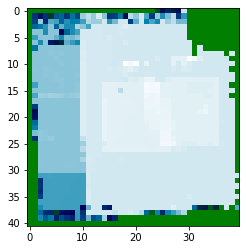

In [46]:
plt.imshow(CHM, cmap='ocean')
plt.show()

Great! We got the CHM file. Now we can plot it in 3D using the plotly library.

### Creating the 3D House 

Since we were able to get the CHM file, we just need to plot it to get the 3D representation. To do that, we will use the plotly library. 

It will then plot a 3D representation of the CHM for the address that you wanted.


In [47]:
fig = go.Figure(data=go.Surface(z=CHM))
fig.update_layout(title=f"This is a 3D representation of {address}")
fig.show()
fig.write_image(f"data/3D-images/{address}.png")

##### Congratulations! You just plotted a 3D represenatation of an address! Hope you had fun!